# How to disable streaming for models that don't support it

<div class="admonition tip">
    <p class="admonition-title">Prerequisites</p>
    <p>
        This guide assumes familiarity with the following:
        <ul>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#streaming">
                    streaming
                </a>                
            </li>
            <li>
                <a href="https://python.langchain.com/docs/concepts/#chat-models/">
                    Chat Models
                </a>
            </li>
        </ul>
    </p>
</div> 

Some chat models, including the new O1 models from OpenAI (depending on when you're reading this), do not support streaming. This can lead to issues when using the [astream_events API](https://python.langchain.com/docs/concepts/#astream_events), as it calls models in streaming mode, expecting streaming to function properly.

In this guide, we’ll show you how to disable streaming for models that don’t support it, ensuring they they're never called in streaming mode, even when invoked through the astream_events API.

In [4]:
from langchain_openai import ChatOpenAI
from langgraph.graph import MessagesState
from langgraph.graph import StateGraph, START, END

llm = ChatOpenAI(model="o1-preview", temperature=1)

graph_builder = StateGraph(MessagesState)


def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

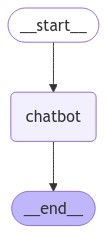

In [5]:
from IPython.display import Image, display

display(Image(graph.get_graph().draw_mermaid_png()))

## Without disabling streaming

Now that we've defined our graph, let's try to call `astream_events` without disabling streaming. This should throw an error because the `o1` model does not support streaming natively:

In [6]:
input = {"messages": {"role": "user", "content": "how many r's are in strawberry?"}}
try:
    async for event in graph.astream_events(input, version="v2"):
        if event["event"] == "on_chat_model_end":
            print(event["data"]["output"].content, end="", flush=True)
except:
    print("Streaming not supported!")

Streaming not supported!


An error occurred as we expected, luckily there is an easy fix!

## Disabling streaming

Now without making any changes to our graph, let's set the [disable_streaming](https://python.langchain.com/api_reference/core/language_models/langchain_core.language_models.chat_models.BaseChatModel.html#langchain_core.language_models.chat_models.BaseChatModel.disable_streaming) parameter on our model to be `True` which will solve the problem:

In [7]:
llm = ChatOpenAI(model="o1-preview", temperature=1, disable_streaming=True)

graph_builder = StateGraph(MessagesState)


def chatbot(state: MessagesState):
    return {"messages": [llm.invoke(state["messages"])]}


graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)
graph = graph_builder.compile()

And now, rerunning with the same input, we should see no errors:

In [8]:
input = {"messages": {"role": "user", "content": "how many r's are in strawberry?"}}
async for event in graph.astream_events(input, version="v2"):
    if event["event"] == "on_chat_model_end":
        print(event["data"]["output"].content, end="", flush=True)

There are three "r"s in the word "strawberry".